In [1]:
#Tensorflow library. Used to implement machine learning models
import tensorflow as tf
#Numpy contains helpful functions for efficient mathematical calculations
import numpy as np
#Dataframe manipulation library
import pandas as pd
#Graph plotting library
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import mean_squared_error as MSE,mean_absolute_error
from tabulate import tabulate
from sklearn.model_selection import train_test_split

import csv

Using TensorFlow backend.


In [2]:
name=['UserID','MovieID','Rating','Timestamp']
ratings_dfx=pd.read_csv('ml-25m/ratings.csv',names=name,skiprows=1,header=None)
ratings_dfx.head()

,UserID,MovieID,Rating,Timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [3]:
ratings_dfx=ratings_dfx.iloc[:,:3]

In [4]:
ratings_dfx.head()

,UserID,MovieID,Rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [5]:
# ratings_dfx.dtypes()

In [6]:
ratings_dfx=ratings_dfx.iloc[:1500000,:1111]
len(ratings_dfx)

1500000

In [7]:
# ratings_dfx=ratings_dfx.iloc[:,:1111]
# len(ratings_dfx)

In [8]:
# ratings_dfx=np.float16(ratings_dfx)


user_rating_dfx = ratings_dfx.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_dfx.head()
#写入 Q.csv 文件中
# with open ("ml-25m/user_rating.csv","w",newline="") as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerows(user_rating_dfx)



MovieID,1,2,3,4,5,6,7,8,9,10,...,208112,208507,208513,208515,208715,208737,208787,208793,208939,209163
UserID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
len(user_rating_dfx)

10025

In [10]:
user_rating_dfx=user_rating_dfx.iloc[:10000,:]

In [11]:
# user_rating_dfx[user_rating_dfx.index==478]

In [12]:
# user_rating_dfx=pd.read_csv('ml-25m/user_rating.csv')

user_rating_dfx[user_rating_dfx.index==215]

MovieID,1,2,3,4,5,6,7,8,9,10,...,208112,208507,208513,208515,208715,208737,208787,208793,208939,209163
UserID,,,,,,,,,,,,,,,,,,,,,
215,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
len(user_rating_dfx)

10000

In [14]:
# user_rating_dfx.to_csv("ml-25m/user_rating.csv",index='UserID')

In [15]:
# user_rating_dfx=pd.read_csv('ml-25m/user_rating.csv',dtype='float32')
# user_rating_dfx.head()

In [16]:

norm_user_rating_dfx = user_rating_dfx.fillna(0) / 5.0
trXx = norm_user_rating_dfx.values
trXx[0:5]

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0.7, 0. , 0. , ..., 0. , 0. , 0. ],
       [0.8, 0. , 0. , ..., 0. , 0. , 0. ],
       [0.6, 0. , 0. , ..., 0. , 0. , 0. ],
       [0.8, 0. , 0. , ..., 0. , 0. , 0. ]])

In [17]:
trXx[215]
#ratings_df[( ratings_df['UserID']==21)].sort_values(by=['MovieID'],ascending=True)

array([0.8, 0.6, 0. , ..., 0. , 0. , 0. ])

In [18]:
# device=tf.device('/GPU:0')

In [19]:
errors_DBNx=[]
class RBM(object):
#     tf.device('/GPU:0')
    def __init__(self, input_size, output_size):
        # Defining the hyperparameters
        self._input_size = input_size  # Size of input
        self._output_size = output_size  # Size of output
        self.epochs = 15  # Amount of training iterations
        self.learning_rate = 1  # The step used in gradient descent
        self.batchsize = 200  # The size of how much data will be used for training per sub iteration

        # Initializing weights and biases as matrices full of zeroes
        self.w = np.zeros([input_size, output_size], np.float32)  # Creates and initializes the weights with 0
        self.hb = np.zeros([output_size], np.float32)  # Creates and initializes the hidden biases with 0
        self.vb = np.zeros([input_size], np.float32)  # Creates and initializes the visible biases with 0

    # Fits the result from the weighted visible layer plus the bias into a sigmoid curve
    def prob_h_given_v(self, visible, w, hb):
        # Sigmoid
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    # Fits the result from the weighted hidden layer plus the bias into a sigmoid curve
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    # Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    # Training method for the model
    def train(self, X):
        # Create the placeholders for our parameters
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])

        prv_w = np.zeros([self._input_size, self._output_size],
                         np.float32)  # Creates and initializes the weights with 0
        prv_hb = np.zeros([self._output_size], np.float32)  # Creates and initializes the hidden biases with 0
        prv_vb = np.zeros([self._input_size], np.float32)  # Creates and initializes the visible biases with 0

        cur_w = np.zeros([self._input_size, self._output_size], np.float32)
        cur_hb = np.zeros([self._output_size], np.float32)
        cur_vb = np.zeros([self._input_size], np.float32)
        v0 = tf.placeholder("float", [None, self._input_size])

        # Initialize with sample probabilities
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)

        # Create the Gradients
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)

        # Update learning rates for the layers
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)

        # Find the error rate
        err = tf.reduce_mean(tf.square(v0 - v1))
        
#         errors=[]

        # Training loop
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            # For each epoch
            for epoch in range(self.epochs):
                # For each step/batch
                for start, end in zip(range(0, len(X), self.batchsize), range(self.batchsize, len(X), self.batchsize)):
                    batch = X[start:end]
                    # Update the rates
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error=sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                errors_DBNx.append(error)
                
                print('Epoch: %d' % epoch, 'reconstruction error: %f' % error)
                
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            
#         plt.plot(errors)
#         plt.ylabel('Error')
#         plt.xlabel('Epoch')
#         plt.show()

    # Create expected output for our DBN
    def rbm_outpt(self, X):
#         X=tf.cast(X,tf.float32)
        input_X = tf.constant(X)
        input_X=tf.cast(input_X,tf.float32)
        _w = tf.constant(self.w)
        _w=tf.cast(_w,tf.float32)
        _hb = tf.constant(self.hb)
#         out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        out=tf.nn.softmax(tf.matmul(input_X, _w) + _hb)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out)

In [20]:
RBM_hidden_sizes = [10000, 5000] #create 4 layers of RBM with size 785-500-200-50

#Since we are training, set input as training data
inpX = trXx

#Create list to hold our RBMs
rbm_list = []

#Size of inputs is the number of inputs in the training set
input_size = inpX.shape[1]

#For each RBM we want to generate
for i, size in enumerate(RBM_hidden_sizes):
    print('RBM: ',i,' ',input_size,'->', size)
    rbm_list.append(RBM(input_size, size))
    input_size = size

RBM:  0   24331 -> 10000
RBM:  1   10000 -> 5000


In [21]:
#For each RBM in our list
for rbm in rbm_list:
    print('New RBM:')
    #Train a new one
    rbm.train(inpX) 
    #Return the output layer
    inpX = rbm.rbm_outpt(inpX)


New RBM:
Instructions for updating:
Use `tf.cast` instead.
Epoch: 0 reconstruction error: 0.027269
Epoch: 1 reconstruction error: 0.016836
Epoch: 2 reconstruction error: 0.013392
Epoch: 3 reconstruction error: 0.011677
Epoch: 4 reconstruction error: 0.010679
Epoch: 5 reconstruction error: 0.010001
Epoch: 6 reconstruction error: 0.009541
Epoch: 7 reconstruction error: 0.009194
Epoch: 8 reconstruction error: 0.008920
Epoch: 9 reconstruction error: 0.008694
Epoch: 10 reconstruction error: 0.008540
Epoch: 11 reconstruction error: 0.008396
Epoch: 12 reconstruction error: 0.008276
Epoch: 13 reconstruction error: 0.008155
Epoch: 14 reconstruction error: 0.008071
New RBM:
Epoch: 0 reconstruction error: 0.000000
Epoch: 1 reconstruction error: 0.000000
Epoch: 2 reconstruction error: 0.000000
Epoch: 3 reconstruction error: 0.000000
Epoch: 4 reconstruction error: 0.000001
Epoch: 5 reconstruction error: 0.000002
Epoch: 6 reconstruction error: 0.000005
Epoch: 7 reconstruction error: 0.000015
Epoch: 

In [22]:
ratings_dfd=pd.read_csv('doubanmovies/ratings.csv')
ratings_dfd.head()

,RATING_ID,USER_MD5,MOVIE_ID,RATING,RATING_TIME
0,1359352573,0ab7e3efacd56983f16503572d2b9915,5113101,2,2018-09-05 19:42:07
1,1598245094,84dfd3f91dd85ea105bc74a4f0d7a067,5113101,1,2019-07-09 14:52:07
2,311937819,c9a47fd59b55967ceac07cac6d5f270c,3718526,3,2010-11-05 22:15:44
3,457663846,18cbf971bdf17336056674bb8fad7ea2,3718526,4,2011-11-14 22:31:02
4,313277849,47e69de0d68e6a4db159bc29301caece,3718526,4,2010-11-09 12:41:11


In [23]:
ratings_dfd.columns=['RatingID','UserID','MovieID','Rating','Rating_time']
ratings_dfd.head()

,RatingID,UserID,MovieID,Rating,Rating_time
0,1359352573,0ab7e3efacd56983f16503572d2b9915,5113101,2,2018-09-05 19:42:07
1,1598245094,84dfd3f91dd85ea105bc74a4f0d7a067,5113101,1,2019-07-09 14:52:07
2,311937819,c9a47fd59b55967ceac07cac6d5f270c,3718526,3,2010-11-05 22:15:44
3,457663846,18cbf971bdf17336056674bb8fad7ea2,3718526,4,2011-11-14 22:31:02
4,313277849,47e69de0d68e6a4db159bc29301caece,3718526,4,2010-11-09 12:41:11


In [24]:
len(ratings_dfd)

4169420

In [25]:
ratings_dfd=ratings_dfd.iloc[:60000,:]

In [26]:
len(ratings_dfd)

60000

In [27]:
user_rating_dfd = ratings_dfd.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_dfd.head()

MovieID,1292568,1292627,1292629,1292688,1292878,1292899,1292903,1292998,1293008,1293066,...,30419844,30441128,30446698,30462403,30465748,30468266,30482802,33405208,33414510,33456096
UserID,,,,,,,,,,,,,,,,,,,,,
0001773246f25b3c7ab97ce05af9dafa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002296a304732a414f3cffb07bc7c3c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00034e6ca83cce11c894376bda67bdd9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00045aa2be0e6e6cd020444f7b0d7feb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0007d6911bc813d01bfec69348fe1316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
len(user_rating_dfd)

35226

In [29]:
user_rating_dfd=user_rating_dfd.iloc[:10000,:]
len(user_rating_dfd)

10000

In [30]:
user_rating_dfd[user_rating_dfd.index=='00034e6ca83cce11c894376bda67bdd9']

MovieID,1292568,1292627,1292629,1292688,1292878,1292899,1292903,1292998,1293008,1293066,...,30419844,30441128,30446698,30462403,30465748,30468266,30482802,33405208,33414510,33456096
UserID,,,,,,,,,,,,,,,,,,,,,
00034e6ca83cce11c894376bda67bdd9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
norm_user_rating_dfd = user_rating_dfd.fillna(0) / 5.0
trXd = norm_user_rating_dfd.values
trXd[0:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
trXd[215]

array([0., 0., 0., ..., 0., 0., 0.])

In [33]:
errors_DBNd=[]

class RBM(object):
    def __init__(self, input_size, output_size):
        # Defining the hyperparameters
        self._input_size = input_size  # Size of input
        self._output_size = output_size  # Size of output
        self.epochs = 15  # Amount of training iterations
        self.learning_rate = 0.075  # The step used in gradient descent
        self.batchsize = 200  # The size of how much data will be used for training per sub iteration

        # Initializing weights and biases as matrices full of zeroes
        self.w = np.zeros([input_size, output_size], np.float32)  # Creates and initializes the weights with 0
        self.hb = np.zeros([output_size], np.float32)  # Creates and initializes the hidden biases with 0
        self.vb = np.zeros([input_size], np.float32)  # Creates and initializes the visible biases with 0

    # Fits the result from the weighted visible layer plus the bias into a sigmoid curve
    def prob_h_given_v(self, visible, w, hb):
        # Sigmoid
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

    # Fits the result from the weighted hidden layer plus the bias into a sigmoid curve
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)

    # Generate the sample probability
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    # Training method for the model
    def train(self, X):
        # Create the placeholders for our parameters
        _w = tf.placeholder("float", [self._input_size, self._output_size])
        _hb = tf.placeholder("float", [self._output_size])
        _vb = tf.placeholder("float", [self._input_size])

        prv_w = np.zeros([self._input_size, self._output_size],
                         np.float32)  # Creates and initializes the weights with 0
        prv_hb = np.zeros([self._output_size], np.float32)  # Creates and initializes the hidden biases with 0
        prv_vb = np.zeros([self._input_size], np.float32)  # Creates and initializes the visible biases with 0

        cur_w = np.zeros([self._input_size, self._output_size], np.float32)
        cur_hb = np.zeros([self._output_size], np.float32)
        cur_vb = np.zeros([self._input_size], np.float32)
        v0 = tf.placeholder("float", [None, self._input_size])

        # Initialize with sample probabilities
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)

        # Create the Gradients
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)

        # Update learning rates for the layers
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)

        # Find the error rate
        err = tf.reduce_mean(tf.square(v0 - v1))
        
#         errors=[]

        # Training loop
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            # For each epoch
            for epoch in range(self.epochs):
                # For each step/batch
                for start, end in zip(range(0, len(X), self.batchsize), range(self.batchsize, len(X), self.batchsize)):
                    batch = X[start:end]
                    # Update the rates
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error=sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                errors_DBNd.append(error)
                
                print('Epoch: %d' % epoch, 'reconstruction error: %f' % error)
                
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            
#         plt.plot(errors)
#         plt.ylabel('Error')
#         plt.xlabel('Epoch')
#         plt.show()

    # Create expected output for our DBN
    def rbm_outpt(self, X):
#         X=tf.cast(X,tf.float32)
        input_X = tf.constant(X)
        input_X=tf.cast(input_X,tf.float32)
        _w = tf.constant(self.w)
        _w=tf.cast(_w,tf.float32)
        _hb = tf.constant(self.hb)
#         out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        out=tf.nn.softmax(tf.matmul(input_X, _w) + _hb)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out)

In [34]:
RBM_hidden_sizes = [500, 250  ] #create 4 layers of RBM with size 785-500-200-50

#Since we are training, set input as training data
inpX = trXd

#Create list to hold our RBMs
rbm_list = []

#Size of inputs is the number of inputs in the training set
input_size = inpX.shape[1]

#For each RBM we want to generate
for i, size in enumerate(RBM_hidden_sizes):
    print('RBM: ',i,' ',input_size,'->', size)
    rbm_list.append(RBM(input_size, size))
    input_size = size

RBM:  0   1111 -> 500
RBM:  1   500 -> 250


In [35]:
#For each RBM in our list

for rbm in rbm_list:
    print('New RBM:')
    #Train a new one
    rbm.train(inpX) 
    #Return the output layer
    inpX = rbm.rbm_outpt(inpX)


New RBM:
Epoch: 0 reconstruction error: 0.003072
Epoch: 1 reconstruction error: 0.002426
Epoch: 2 reconstruction error: 0.002123
Epoch: 3 reconstruction error: 0.002052
Epoch: 4 reconstruction error: 0.001999
Epoch: 5 reconstruction error: 0.001951
Epoch: 6 reconstruction error: 0.001916
Epoch: 7 reconstruction error: 0.001901
Epoch: 8 reconstruction error: 0.001908
Epoch: 9 reconstruction error: 0.001892
Epoch: 10 reconstruction error: 0.001880
Epoch: 11 reconstruction error: 0.001865
Epoch: 12 reconstruction error: 0.001856
Epoch: 13 reconstruction error: 0.001858
Epoch: 14 reconstruction error: 0.001873
New RBM:
Epoch: 0 reconstruction error: 0.004820
Epoch: 1 reconstruction error: 0.002970
Epoch: 2 reconstruction error: 0.002466
Epoch: 3 reconstruction error: 0.002236
Epoch: 4 reconstruction error: 0.002137
Epoch: 5 reconstruction error: 0.002053
Epoch: 6 reconstruction error: 0.002048
Epoch: 7 reconstruction error: 0.002064
Epoch: 8 reconstruction error: 0.002032
Epoch: 9 reconstr

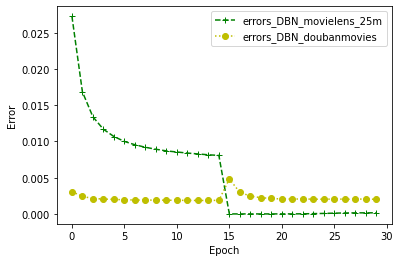

In [36]:
# plt.plot(errors_DBNs,'--*b',label='errors_DBN_movielens_100k')
# plt.plot(errors_DBN,'--or',label='errors_DBN_movielens_1m')
plt.plot(errors_DBNx,'--+g',label='errors_DBN_movielens_25m')
plt.plot(errors_DBNd,'o:y',label='errors_DBN_doubanmovies')

plt.legend()

# x_major_locator=MultipleLocator(0.001)#以每15显示
# y_major_locator=MultipleLocator(5)#以每3显示
# ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)

plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

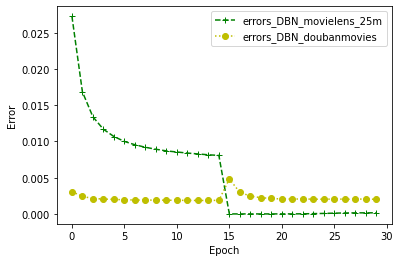

In [37]:
# errors_DBN=errors_DBN[15:30]
# errors_DBNs=errors_DBNs[15:30]
errors_DBNx1=errors_DBNx[15:30]
errors_DBNd1=errors_DBNd[15:30]




# plt.plot(errors_DBNs,'--*b',label='errors_DBN_movielens_100k')
# plt.plot(errors_DBN,'--or',label='errors_DBN_movielens_1m')
plt.plot(errors_DBNx1,'--+g',label='errors_DBN_movielens_25m')
plt.plot(errors_DBNd1,'o:y',label='errors_DBN_doubanmovies')
plt.legend()

# x_major_locator=MultipleLocator(0.001)#以每15显示
# y_major_locator=MultipleLocator(5)#以每3显示
# ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)

plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()